In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'data1/notMNIST.pickle'

with open(pickle_file,'rb') as f:
    save=pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Note that in below code, we added 1 more dimension while reshaping.. This is bcoz , convnets need more 3 or more dims to work correctly in tf

In [30]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)   # <- convs need image as cubes 
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [31]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Now we have to create a small conv logic here..

In [35]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    maxpool = tf.nn.max_pool(hidden1,[1,2,2,1],[1,2,2,1],padding='SAME')
    
    conv = tf.nn.conv2d(maxpool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    maxpool = tf.nn.max_pool(hidden,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    
    shape = maxpool.get_shape().as_list()
    reshape = tf.reshape(maxpool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [36]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 2.932312
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.905028
Minibatch accuracy: 43.8%
Validation accuracy: 58.3%
Minibatch loss at step 100: 1.163847
Minibatch accuracy: 62.5%
Validation accuracy: 63.0%
Minibatch loss at step 150: 1.469929
Minibatch accuracy: 50.0%
Validation accuracy: 70.2%
Minibatch loss at step 200: 1.054058
Minibatch accuracy: 68.8%
Validation accuracy: 71.1%
Minibatch loss at step 250: 0.975698
Minibatch accuracy: 56.2%
Validation accuracy: 78.5%
Minibatch loss at step 300: 1.334408
Minibatch accuracy: 56.2%
Validation accuracy: 70.5%
Minibatch loss at step 350: 0.932324
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 400: 0.648814
Minibatch accuracy: 87.5%
Validation accuracy: 79.8%
Minibatch loss at step 450: 0.934482
Minibatch accuracy: 75.0%
Validation accuracy: 80.6%
Minibatch loss at step 500: 0.854369
Minibatch accuracy: 81.2%
Validation accuracy: 82.8%
M

In [3]:
train_dataset.shape


(200000, 28, 28)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

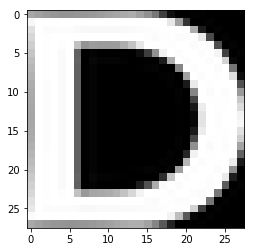

In [7]:
plt.imshow(train_dataset[4],cmap='gray')